# Acquisition and analysis of Image Simulation data from Zemax

<img src="https://raw.githubusercontent.com/indranilsinharoy/PyZDDE/master/Doc/Images/articleBanner_04_acqnanaImageSim.png" height="230">

*Please feel free to [e-mail](mailto:indranil_leo@yahoo.com) any corrections, comments and suggestions to the author ([Indranil Sinharoy](http://indranilsinharoy.com/))*  

Last updated: 12/31/2015

License: [Creative Commons Attribution 4.0 International](https://creativecommons.org/licenses/by/4.0/)

## References

1. [How to Simulate High Resolution Images](http://www.zemax.com/support/resource-center/knowledgebase/how-to-simulate-high-resolution-images), Mark Nicholson, 2008.
2. Image Simulation, Zemax Manual.



The purpose of this notebook is to demonstrate how to use the Image Simulation feature of Zemax using the DDE extension from Python (PyZDDE). This document doesn't aim to include the theory behind the image simulation feature of Zemax. It is also not a substitute for references [1] and/or [2]. Please refer to the Zemax manual and the knowledgebase articles included in the reference for greater understanding of the image simulation feature.


**TOC**

* [Example 1 - Singlet Eyepiece](#Example-1---Singlet-Eyepiece)
    * [Geometric distortion in the system](#Geometric-distortion-in-the-system)
    * [Useful baseline system](#Useful-baseline-system)
* [Example 2 - Double Gauss Experimental Arrangement](#Example-2---Double-Gauss-Experimental-Arrangement)
    * [Heuristic method to estimate oversampling factor](#Heuristic-method-to-estimate-oversampling-factor)
* [Example 3 - A blue notch filter](#Example-3---A-blue-notch-filter)
* [Example 4 - A diffraction limited system](#Example-4---A-diffraction-limited-system)
    * [Effect of increasing oversampling on the PSF grid](#Effect-of-increasing-oversampling-on-the-PSF-grid)
* [Example 5 - Spatially varying resolution](#Example-5---Spatially-varying-resolution)
* [Example 6 - Tilted image plane](#Example-6---Tilted-image-plane)


### Summary

Here are a set of general guidelines.

1. The simulated image is produced essentially in the following three steps:
    * the source bitmap image is convolved with the generated PSF grid in the object space. This object space PSF is space variant and contains information about the optical aberrations of the system. The resulting convolved image doesn't have geometric distortions.
    * following the convolution, the image is transformed from the object space to the image space to account for geometric distortions and system magnification.
    * detector sampling effects (depending on the dimension and the pixel size of the detector, whether default or as specified) are then accounted for before generating the final output.

2. The convolution of the source bitmap image and the object side PSF occurs on a discrete grid. The resolution of this discrete grid--object space pixel size--is determined solely by the specified object field height, the number of pixels (in the vertical direction), and oversampling (if any). The object side pixel size is not determined the specifications of the detector pixels size and dimensions.

3. The fidelity of the PSFs in the object space is determined by the object side pixel size (i.e. the resolution of the discrete object space grid). It is not affected by the detector pixel size and dimensions specifications.

4. In order to produce accurate image simulations, we must ensure that there are sufficient numer of pixels per PSF in the PSF-grid. This can be done visually using the image simulation tool by checking the quality of the PSF and increasing the oversampling or decreasing the field height if required. Alternatively, we can compute the maximum allowable field height or minimum required oversampling based on a criterion of ensuring a minimum number of pixels within the RMS spot size or 98% ensquared spot size. This computation must be done on the "best" PSF--having smallest spot diameter. Doing so, will guarantee the minimum samples in the smallest (and hence also the largest/worst) PSF. Note that if possible, decreasing the field height should chosen over oversampling, because the computation time increases drastically with oversampling.

5. The appropriate value of the "Image Sampling" parameter can be determined based on the worst-case PSF, such that the Image Sampling grid is at least as large as the worst case PSF. Note that the Image sampling doesn't affect the resolution of the PSF grid. However, the Image Sampling determines the "portion" of the computed PSF that will be used for the convolution.

6. The Pupil Sampling parameter controls the fidelity of the PSFs in terms of how accurately the PSFs represent system aberrations.

In [1]:
# imports
from __future__ import division, print_function
import os
import shutil
import collections as co
import numpy as np
from scipy.misc import imsave, imread
import matplotlib.pyplot as plt
import pyzdde.zdde as pyz

In [2]:
%matplotlib inline

#%matplotlib notebook

# use "%matplotlib notebook" to enable better interactivity with the plots.

**NOTE**

The examples considered here are uses the sample Zemax files included in the directory `\Zemax\Samples\Sequential\Image Simulation`. The filenames for each of these files contains a comma, which causes problems when loading the files in to the DDE server programmatically using `zLoadFile()`. Therefore, we'll first make a copy of the existing files and rename them using a filename that doesn't have a comma.

I have also seen that sometimes the function `zGetTextFile(textFileName, analysisType, settingsFile, ...)` (used internally by `zGetImageSimulation()`) fails if the absolute names of both the `textFileName` and `settingsFiles` are very long. In the event of such a failure, an assertion is raised in the image simulation function with the following message:

```python
AssertionError: zGetTextFile() returned error code -1

```

Keeping these conditions in mind, we will use short names for the renamed files.

You can clean up the directory by deleting all newly added files added by calling the function `clean_up_directory()` at the very end of this notebook.


The simulations in this notebook was performed with Zemax 13. All functions except for `ipzCaptureWindow()` will work in the latest version of OpticStudio.

In [3]:
usr = os.path.expandvars("%userprofile%")
imgSimDir = os.path.join(usr, 'Documents\Zemax\Samples\Sequential\Image Simulation')
zmxFilesAdded = [] 

In [4]:
# create a link and load the file
ln = pyz.createLink()

In [5]:
# Helper functions common to all examples

def show_pixel_grid(ax, pixX, pixY, gAlpha=None):
    """plots pixel grid on the given axes 
    
    Parameters
    ----------
    ax : axes object 
        figure axes object 
    pixX : integer
        number of pixels along x/columns
    pixY : integer 
        number of pixels along y/rows
    gAlpha : float (0 < gAlpha <= 1)
        alpha for the pixel grid
        
    Returns
    -------
    None
    """
    gAlpha = gAlpha if gAlpha is not None else 1.0
    xl = np.arange(1, pixX) - 0.5
    yl = np.arange(1, pixY) - 0.5
    ax.xaxis.set_minor_locator(plt.FixedLocator(xl))
    ax.yaxis.set_minor_locator(plt.FixedLocator(yl))
    ax.xaxis.set_tick_params(which='minor', length=0)
    ax.yaxis.set_tick_params(which='minor', length=0)
    ax.xaxis.set_tick_params(which='major', direction='out')
    ax.yaxis.set_tick_params(which='major', direction='out')
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    ax.grid(which='minor', color='r', linestyle='-', linewidth=0.75, 
            alpha=gAlpha)

def show_image(img_data, img_info, figsize=(10, 7.5), xylabels=True, title=True):
    """convert the image data to numpy array and display image
    
    """
    img = np.array(img_data, dtype='uint8')
    fig, ax = plt.subplots(1,1, figsize=figsize)
    if len(img_info)==6: # image simulation data
        bottom, top = -img_info.imgH/2, img_info.imgH/2
        left, right = -img_info.imgW/2, img_info.imgW/2
        extent=[left, right, bottom, top]
        xl, yl = 'Image width (mm)', 'Image height (mm)'
        t = 'Simulated Image'
    elif len(img_info)==4: # psf grid data
        bottom, top = -img_info.objHeight/2, img_info.objHeight/2
        aratio = img_info.xpix/img_info.ypix
        left, right =  bottom*aratio, top*aratio
        extent=[left, right, bottom, top]
        xl, yl = 'Field width (mm)', 'Field height (mm)'
        t = 'PSF Grid at field pos {:2.2f}'.format(img_info.fieldPos)
    else: # source bitmap
        extent = [0, img_info.xpix, 0, img_info.ypix]
        xl = '{} pixels wide'.format(img_info.xpix) 
        yl = '{} pixels high'.format(img_info.ypix)
        t = 'Source Bitmap'
    ax.imshow(img, extent=extent, interpolation='none')
    ax.set_aspect('equal')
    if xylabels:
        ax.set_xlabel(xl); ax.set_ylabel(yl);
    if title:
        ax.set_title(t)
    plt.show()
    
# Helper function to show zoomed in portion

def show_around(img_data, pixX=20, pixY=20, ctrX=None, ctrY=None, 
                pixSize=None, pixGrid=False, retData=False, ax=None):
    """display pixX x pixY pixels around (ctrX, ctrY). 
    
    Parameters
    ----------
    img_data : list of list
        data returned by ln.zGetImageSimulation() 
    pixX : integer 
        number of pixels along x
    pixY : integer, optional
        number of pxiels along y
    ctrX : integer, optional
        center pixel along x
    ctrY : integer, optional 
        center pixel  along y
    pixSize : real, optional
        length of the side of a square pixel.
        if 
    pixGrid : bool, optional
        if True, show pixel grid
    retData : bool, optional, 
        if True, the cropped data is returned
        and not plotted
    ax : axes object
        if passed plt.show() will have to be invoked by the caller

    
    Assumptions
    ------------
    pixX, pixY, ctrX, ctrY are not 0
    """
    img = np.array(img_data, dtype='uint8')
    M, N = img.shape[:2]
    ctrX, ctrY = ctrX or N/2, ctrY or M/2
    pixX, pixY = pixX or 20, pixY or 20
    sRow, eRow = int(ctrY - pixY/2), int(ctrY + pixY/2)
    sCol, eCol = int(ctrX - pixX/2), int(ctrX + pixX/2)
    # ensure bounds are right
    sRow = sRow if sRow >= 0 else 0
    eRow = eRow if eRow <= M else M
    sCol = sCol if sCol >= 0 else 0
    eCol = eCol if eCol <= N else N
    data = img[sRow:eRow, sCol:eCol, :]
    if retData:
        return data
    else:
        if not ax:
            fig, ax = plt.subplots(1, 1, figsize=(5.5, 5.5))
        iAlpha = 0.8 if pixGrid else 1.0
        ax.imshow(data, interpolation='none', zorder=15, alpha=0.8)
        ax.set_xlabel('pixels', fontsize=10) 
        ax.set_ylabel('pixels', fontsize=10)
        if pixGrid:
            show_pixel_grid(ax=ax, pixX=pixX, pixY=pixY)
        if pixSize:
            # create a secondary axes
            ax2 = ax.twiny()
            ax3 = ax2.twinx()
            wideX = pixSize*(eCol-sCol)
            wideY = pixSize*(eRow-sRow)
            ax.xaxis.set_ticks_position('bottom') # required
            ax.yaxis.set_ticks_position('left')   # required
            ax2.set_xlim(0, wideX)
            ax3.set_ylim(wideY, 0)
            ax2.set_xlabel('phy. dim.', fontsize=10) 
            ax3.set_ylabel('phy. dim.', fontsize=10)
            ws = 'Width: {:2.3f}'.format(wideX)
            hs = 'Height: {:2.3f}'.format(wideY)
            ax.text(x=0.99, y=0.055, s=ws, transform = ax.transAxes, 
                    color='w', zorder=16, alpha=0.65, horizontalalignment='right')
            ax.text(x=0.99, y=0.02, s=hs, transform = ax.transAxes, 
                    color='w', zorder=16, alpha=0.65, horizontalalignment='right')
        if not ax:
            ax.set_aspect('equal')
            plt.show()

In [61]:
# arguments to the function zSetImageSimulationsSettings()

X2, X4, X8, X16, X32 = 1, 2, 3, 4, 5  # oversampling
RGB = 0                               # Wavelength
GEOM, DIFF = 1, 2                     # Aberration
S32by32, S64by64, S128by128 = 1, 2, 3 # Pupil/Image Sampling
CHIEF, VERTEX = 0, 1                  # reference
SIMIMG, SRCBMP, PSFGRID = 0, 1, 2     # show as 

## Example 1 - Singlet Eyepiece

In [7]:
zmf_src = 'Example 1, A singlet eyepiece.ZMX'
zmf_dst = 'A Singlet Eyepiece.ZMX'
lens_src = os.path.join(imgSimDir, zmf_src)
lens_dst = os.path.join(imgSimDir, zmf_dst)

In [8]:
# copy and create new zmx file
shutil.copyfile(lens_src, lens_dst)
zmxFilesAdded.append(lens_dst)

In [9]:
# Load the lens file
ln.zLoadFile(lens_dst)

0

In [10]:
# Lens notes retrieved from the prescription file 
ln.ipzGetTextWindow('Pre', 7, 17)

LENS NOTES:

An input bitmap (left) is convolved with a PSF Grid (middle) to form the output image
(right). Note that screen resolution may mean that not all elements in the 7x7 grid
appear in the middle window: simply maximize the window to see the entire grid.

Note the distortion, and the variation of focus over the field of view.

This lens is so highly aberrated that the relative illumination (variation of brightness
over the image) cannot be computed: note the warning in the bottom of the right-most
Image Simulation window.


Now we will create a settings file to control the image simulation as described in [1]. 

Note that if we don't specify the proper settings, the image simulation can produce unexpected results, because Zemax may use the image simulation settings from a previously produced cfg/settings file.

I highly recommend that you create the settings file everytime before invoking the image simulation through the DDE extension. The image simulation function (`zGetImageSimulation()`) may fail with an error message like 

```python 
IO Error: [Errno 2] No such file or directory: [...]
``` 

if no settings files are given to the `zGetImageSimulation()` function.

In [11]:
cfgfile = ln.zSetImageSimulationSettings(image='Demo picture -  640 x 480.bmp',
                                         height=13.8, field=1, wave=RGB,
                                         pupilSample=S32by32, imgSample=S32by32, 
                                         psfx=7, psfy=7, pixelSize=1.3, 
                                         xpix=640, ypix=480, aberr=DIFF,
                                         showAs=SIMIMG, reference=CHIEF,
                                        )

Now we call image simulation function. The function returns a tuple containing some metadata that can be useful for plotting (amongst other things) and the simulated data. The simulated data is a standard Python list of 8 bit unsigned integers. We will convert the returned list to Numpy's ndarray for display (and further processing if required). 

Also note that some image simulation can take a long time. The default timeout for the function `ln.zGetImageSimulation()` is 180 seconds. If the image simulation takes longer than the set timeout, the function  fails and returns a timeout message.  

In [12]:
img_info, img_data = ln.zGetImageSimulation(settingsFile=cfgfile)

In [13]:
# meta-data produced for the image simulation
img_info

ImgSimInfo(xpix=640, ypix=480, objHeight=13.8, fieldPos=0.0, imgW=832.0, imgH=624.0)

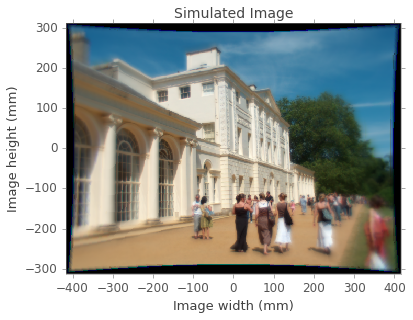

In [13]:
# the simulated image
show_image(img_data, img_info, figsize=(6, 4.5))

To produce the PSF grid, we will modify the settings file (`cfgfile`) that we used above, using the funciton `zModifyImageSimulationSettings()`


In [14]:
ln.zModifyImageSimulationSettings(settingsFile=cfgfile, showAs=PSFGRID)

(0,)

In [15]:
img_info, img_data = ln.zGetImageSimulation(settingsFile=cfgfile)

In [16]:
# meta-data produced for the psf grid. Notice the change in the metadata information
img_info

PSFGridInfo(xpix=640, ypix=480, objHeight=13.8, fieldPos=0.0)

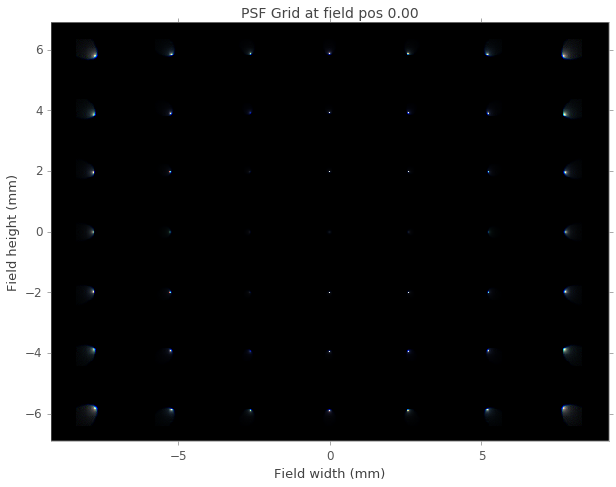

In [17]:
# PSF field in the object plane
show_image(img_data, img_info)

As shown in the above figure, the PSF grid spans the field size whose height is specified in the settings file, and whose width is determined by the pixel aspect ratio of the source bitmap image and the field height (see the function `show_image()`.)

The simulated image (in the object space) is produced by convolving the PSF with the source bitmap image at every pixel in the object field. The PSF at each pixel location is determined by interpolating neighbouring computed PSFs in the PSF Grid. Following the (space variant) convolution or super-position integral in the object space, the simulated image is transformed into the image space based on the system parameters (for e.g. magnification, aberrations, geometric distortions, pixel size and number of pixels, etc.)   


To show the source bitmap file, we will modify the settings file:

In [18]:
ln.zModifyImageSimulationSettings(settingsFile=cfgfile, showAs=SRCBMP)

(0,)

In [19]:
img_info, img_data = ln.zGetImageSimulation(settingsFile=cfgfile)

In [20]:
img_info

SrcImgInfo(xpix=640, ypix=480)

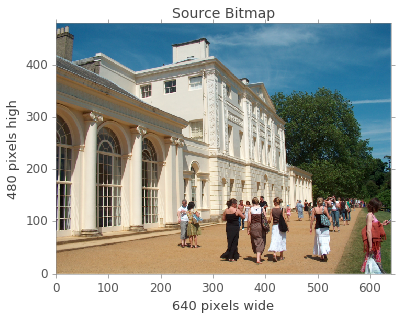

In [21]:
show_image(img_data, img_info, figsize=(6, 4.5))

#### Geometric distortion in the system

Setting both `psfx` and `psfy` points to 1 will result in the use of just one PSF (generated at the center of the field) being used for the entire field. Furthermore, setting the `Aberrations` to `None` will in the PSF being a *delta function*. Under these settings, the image simulation will produce an image affected only the geometric distortions of the system.

In [22]:
ln.zModifyImageSimulationSettings(settingsFile=cfgfile, showAs=SIMIMG, aberr=None, psfx=1, psfy=1)

(0, 0, 0)

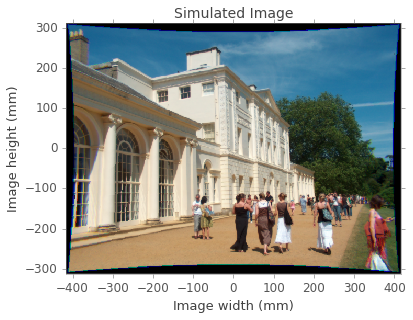

In [23]:
img_info, img_data = ln.zGetImageSimulation(settingsFile=cfgfile)
show_image(img_data, img_info, figsize=(6, 4.5))

#### Useful baseline system

Setting `pixelSize`, `xpix`, and `ypix` to `0` enforces Zemax to set the number of detector pixels to be equal to the number of pixels in the source bitmap. The detector pixel size will be set equal to the size of the central pixel in the source bitmap scaled by the optical system's magnification. 

In [24]:
# setting pixelSize, xpix and ypix to default
ln.zModifyImageSimulationSettings(settingsFile=cfgfile, aberr=DIFF, psfx=7, psfy=7, 
                                  pixelSize=0, xpix=0, ypix=0)

(0, 0, 0, 0, 0, 0)

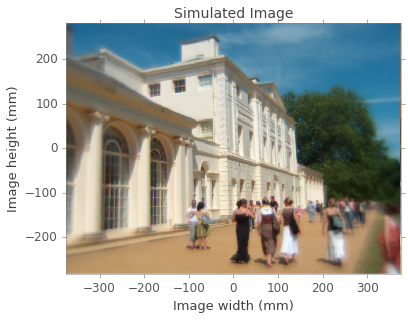

In [25]:
img_info, img_data = ln.zGetImageSimulation(settingsFile=cfgfile)
show_image(img_data, img_info, figsize=(6, 4.5))

## Example 2 - Double Gauss Experimental Arrangement

In [26]:
zmf_src = 'Example 2, Double Gauss Experimental Arrangement.ZMX'
zmf_dst = 'Double Gauss Experimental.ZMX'
lens_src = os.path.join(imgSimDir, zmf_src)
lens_dst = os.path.join(imgSimDir, zmf_dst)
shutil.copyfile(lens_src, lens_dst)
zmxFilesAdded.append(lens_dst)
ln.zLoadFile(lens_dst)

0

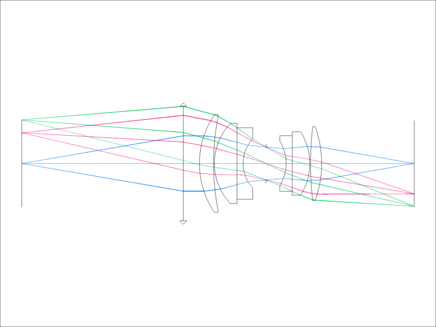

In [27]:
# Layout plot of the system 
# (currently ipzCaptureWindow() function doesn't work in the new OpticStudio)
ln.ipzCaptureWindow('Lay')

In [28]:
# Lens notes from the prescription file
ln.ipzGetTextWindow('Pre', 7, 16)

LENS NOTES:

A double-Gauss lens was optimized with the object at infinity and with the field
of view defined in angles. This example shows a typical experimental arrangement
in which a source scene is modeled using a bitmap to represent a test chart, and
the light from that scene is collimated using an auxiliary optical system. This allows
spatial frequencies in the object plane to be defined in cycles/mm, and for the resulting
contrast to be measured in the image plane.

Note the darkening of the image towards the corners.


Although it is recommended to first inspect the PSF grid (and start with a baseline simulation) before performing the image simulation, let's proceed with the simulation as presented in [1]. Please keep in mind that the purpose of this example in [1] is mostly to show the effect of light fall-off around the edges.

In [29]:
# generate a new settings file
# Note that the input source is rotated by 180° (flip=1), the reference is vertex
# and xpix, ypix and pixel sizes are not specified. 
cfgfile = ln.zSetImageSimulationSettings(image='Demo picture -  640 x 480.bmp',
                                         height=54, field=None, wave=RGB, flip=1,
                                         pupilSample=S32by32, imgSample=S32by32, 
                                         psfx=7, psfy=7, aberr=DIFF,
                                         showAs=SIMIMG, reference=VERTEX,
                                        )

In [30]:
img_info, img_data = ln.zGetImageSimulation(settingsFile=cfgfile)
img_info

ImgSimInfo(xpix=640, ypix=480, objHeight=54.0, fieldPos=0.0, imgW=71.5297, imgH=53.6473)

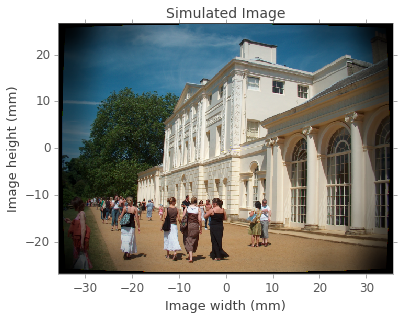

In [31]:
show_image(img_data, img_info, figsize=(6, 4.5))

Observe that although, there is light falloff around the edges, the image looks very sharp--almost as sharp as the source bitmap, i.e the object. (If you started matplotlib with the *notebook* backend by executing `%matplotlib notebook`, zoom-in to see all the jagged edges.)

To find out what's going on, let's look at the PSF grid.

In [32]:
ln.zModifyImageSimulationSettings(settingsFile=cfgfile, showAs=PSFGRID)

(0,)

In [33]:
img_info, img_data = ln.zGetImageSimulation(settingsFile=cfgfile)
img_info

PSFGridInfo(xpix=640, ypix=480, objHeight=54.0, fieldPos=0.0)

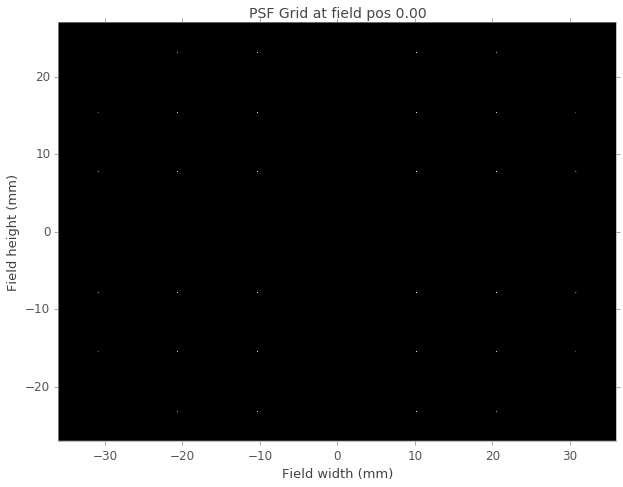

In [34]:
show_image(img_data, img_info)

If we zoom-in we can observe that most of the PSFs, especially near the center, are just delta functions. The figure below shows 20 pixels by 20 pixels (2.5 mm x 2.5 mm region) around the on-axis pixel. 

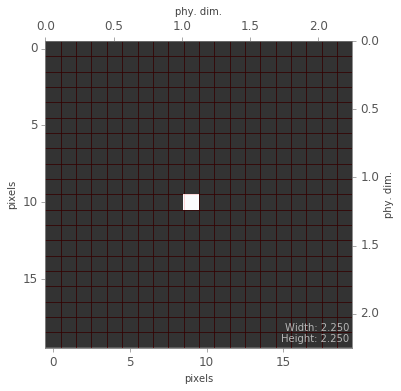

In [36]:
# zoomed-in to the central PSF in the field (object field)
show_around(img_data, pixX=20, pixY=20, pixGrid=True, pixSize=img_info.objHeight/img_info.ypix)

In the above pixel (and in most of the pixels across the field) the PSF just coalesced into a delta function. All information about the system's resolution and aberrations are lost. The reason for this that the object space pixels are too large compared to the physical extent of the actual PSFs. In other words, the resolution of the object plane grid is insufficient. To rectifiy, we must either use an appropriate oversampling factor or decrease the object field height by an appropriate factor. 


#### Heuristic method to estimate oversampling factor

We could figure out the appropriate settings by trying out different oversampling factors or various field heights in the image simulation dialog box. Alternatively, we can estimate the required oversampling and/or field height for adequate sampling of the PSF.

The main idea is the we can estimate the (worst case) PSF diameter in the object space either from diffraction or ray trace based calculation. Then, we set a criterion for the desired number of pixels in the PSF spot. Based on this criterion and the number of pixels in the source bitmap, we can estimate the oversampling factor.

In [37]:
# Here is a quick and dirty helper function to estimate the size 
# of the PSF in the image plane.

def get_spot_dia(ln,  spotType='rms', whichWave='pri', hy=0, field=1, frac=0.98):
    """returns diffraction limited, RMS spot or encircled energy fraction based
    diameter in the image plane in microns.

    Parameters
    ----------
    ln : object 
        pyzdde link object
    spotType : 3 letter string code ('rms', 'diff', 'enc')
        'diff' for diffraction limited airy spot diameter, 
        'rms' for RMS spot diameter
        'enc' : greater of diffraction encircle (ensquared) energy or 
        and geometric encircle energy  
    whichWave : 3 letter string code ('pri' or 'gre')
        wavelength - 'pri' for primary wave, 'gre' for greatest.
        (applicable only for diffraction limited spot computation. `rms` 
         and `enc` uses weighted polychromatic wavelength)
    hy : real (0 <= hy <= 1), optional 
        normalized field height (applicable only for `rms` spot). 
    field : integer, optional  
        field number (applicable only for `enc` computation). 
    frac : real (0 < frac <=1), optional 
        fraction for encircled energy calculation  
        
    Returns
    -------
    spotDia : real
        spot diameter in microns

    Notes
    ----- 
    1. The diffraction stop ('diff') returns on-axis airy diameter 
    2. For paraxial systems, the 'rms' spot radius will zero or very close
       to zero. Use diffraction limited spot diameter or encircled energy 
       for such systems.
    3.  
    """
    if spotType =='diff':    
        if whichWave=='pri':
            wave = ln.zGetWaveTuple().wavelengths[ln.zGetPrimaryWave()-1]
        else:
            waveTuple = list(ln.zGetWaveTuple().wavelengths)
            waveTuple.sort()
            wave = waveTuple[-1]
        fnum = ln.zGetFirst().paraWorkFNum
        diffLimSpotDia = 2.44*wave*fnum # in microns
        return diffLimSpotDia
    elif spotType=='rms': # RMS spot 
        rmsOperC = ['RSCE', 'RSCH']  # GQ usg. circ. grid
        rmsOperR = ['RSRE', 'RSRH']  # usg. rect. grid of rays
        rmsSpotC, rmsSpotR = [], []
        hx = 0
        hy = hy if hy is not None else 0
        ring, samp, wave, hx = 6, 10, 0, 0 
        for oper in rmsOperC:
            rmsSpotC.append(ln.zOperandValue(oper, ring, wave, hx, hy))
        for oper in rmsOperR:
            rmsSpotR.append(ln.zOperandValue(oper, samp, wave, hx, hy))
        rmsSpots = rmsSpotC + rmsSpotR
        rmsSpotDia = 2.0*np.median(rmsSpots)*1000 # microns
        return rmsSpotDia
    elif spotType=='enc': # encircled energy 
        samp, wave, etype = 2, 0, 4
        field = field if field is not None else 1
        denc = ln.zOperandValue('DENC', samp, wave, field, frac, etype, 3, 0, 0)
        genc = ln.zOperandValue('GENC', samp, wave, field, frac, etype, 0, 0, 0)
        return genc if genc > denc else denc 
    else:
        raise ValueError, 'Incorrect spot type'

In [38]:
# PSF/spot size @ Image plane for the on-axis PSF
diffLimSpotDiaImg = get_spot_dia(ln, spotType='diff')
rmsSpotDiaImg = get_spot_dia(ln, spotType='rms')
encSpotDiaImg = get_spot_dia(ln, spotType='enc')
print("Diffraction limited spot diameter in image "
      "plane is {:2.4f} microns".format(diffLimSpotDiaImg))
print("RMS spot diameter in image plane is {:2.4f} microns"
      .format(rmsSpotDiaImg))
print("Ensquared spot length in image plane is {:2.4f} microns"
      .format(encSpotDiaImg))

Diffraction limited spot diameter in image plane is 4.1830 microns
RMS spot diameter in image plane is 15.4600 microns
Ensquared spot length in image plane is 13.6153 microns


In [39]:
# If we desire to have atleast 2 pixel across the diameter (assuming circular) of  PSF, 
# then the desire pixel size is spot_diameter/number_of_pixels.

# For this example, we will consider the RMS spot
# Note that the actual spread of the PSF is slightly larger than the RMS, especially 
# as we go off-axis, we will have more than 2 pixels really.

desPixelSize = rmsSpotDiaImg/2.0
desPixelSize  # in microns

7.7300003750000004

In [41]:
# original field height in the image space
fieldHeightObj = 54  # (originally set)
fieldHeightImg = fieldHeightObj*abs(ln.zGetMagnification()) # ignoring distortions; paraxial
fieldHeightImg  

53.07836607564422

In [42]:
# resulting pixel size with the original settings
numPixelsY = 480
pixelSizeImg = (fieldHeightImg*1000)/numPixelsY
pixelSizeImg # in microns

110.57992932425879

The above pixel size is really large compared to the spot diameter. Consequently, most of the PSFs in the field are just delta functions.

Let's reduce the field height only first and see if we can get "good" PSFs. (The image simulation with the reduced field height should be at least as fast as the one we just did. Oversampling will increase the simulation time drastically.)

In [43]:
# computation of field height (in object) in mm such that we have at least 
# 2 pixels within the RMS spot size
numPixelsY*(desPixelSize/1000.)*abs(ln.zGetMagnification())

3.6470736859477078

In [44]:
# we set the field height to 3.6 mm and retrieve the PSF grid
ln.zModifyImageSimulationSettings(settingsFile=cfgfile, height=3.6)
img_info, img_data = ln.zGetImageSimulation(settingsFile=cfgfile)
img_info

PSFGridInfo(xpix=640, ypix=480, objHeight=3.6, fieldPos=0.0)

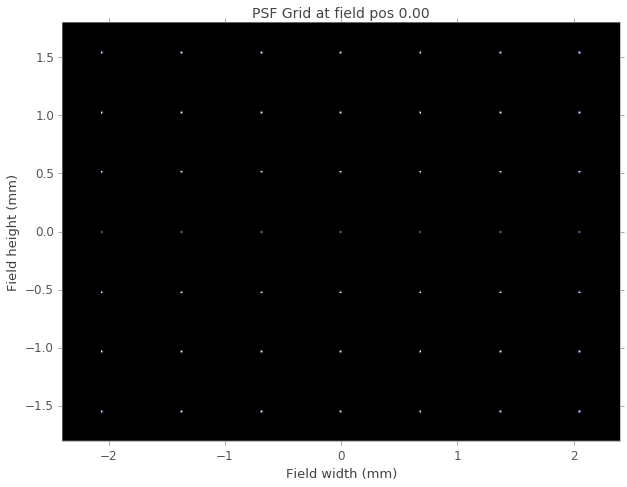

In [45]:
show_image(img_data, img_info)

The on-axis PSF in the above PSF grid has between 3-5 pixels (depending on the orientation of the diagonal along with the pixels are measured). 

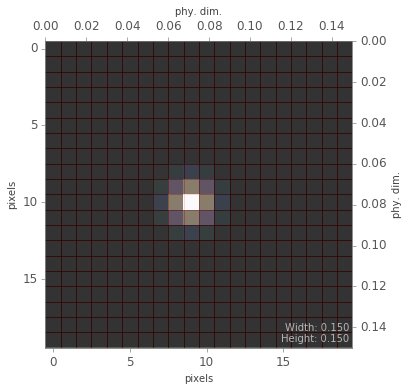

In [48]:
# 20x20 pixel region around the center
show_around(img_data, pixX=20, pixY=20, pixGrid=True, pixSize=img_info.objHeight/img_info.ypix)

Now, let's perform the image simulation.

In [49]:
# Modify the settings, to show the image
ln.zModifyImageSimulationSettings(settingsFile=cfgfile, showAs=SIMIMG)

(0,)

In [50]:
img_info, img_data = ln.zGetImageSimulation(settingsFile=cfgfile)
img_info

ImgSimInfo(xpix=640, ypix=480, objHeight=3.6, fieldPos=0.0, imgW=4.7686, imgH=3.5765)

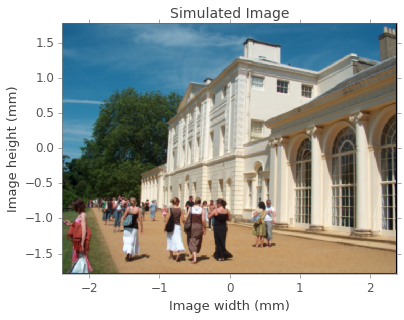

In [51]:
show_image(img_data, img_info, figsize=(6, 4.5))

The above picture is only relatively smoother than the original. However, there is no light fall-off effect. Why? This is because the field is too small for the aberrations to take effect!

Note that even now, the PSF is not adequately represented. In the following simulation, we set the object height to 0.1 mm. For this setting (without any oversampling), the object side pixel is `(0.1/480)*1000 = 0.20833 microns`, resulting in about `15.46/0.20833 = 74.2` pixels per rms spot size. 

In [59]:
# Modify the settings, to show the PSF grid, and change the field height to 0.1 mm
# Since the field is very small, we don't expect the PSF to change that much within
# the field, so we create only 3x3 PSF grid, in the following example we also increase
# the image sampling from 32x32 to 64x64
ln.zModifyImageSimulationSettings(settingsFile=cfgfile, height=0.1, 
                                  imgSample=S64by64, psfx=3, psfy=3,
                                  showAs=PSFGRID)

(0, 0, 0, 0, 0)

In [62]:
img_info, img_data = ln.zGetImageSimulation(settingsFile=cfgfile)
img_info

PSFGridInfo(xpix=640, ypix=480, objHeight=0.1, fieldPos=0.0)

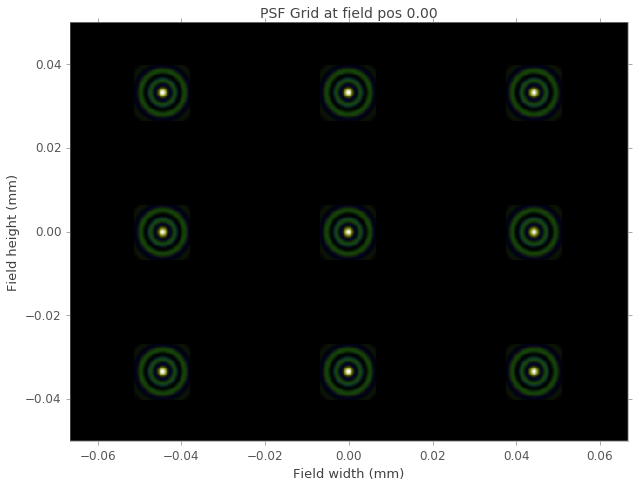

In [63]:
# PSF field in the object plane
show_image(img_data, img_info)

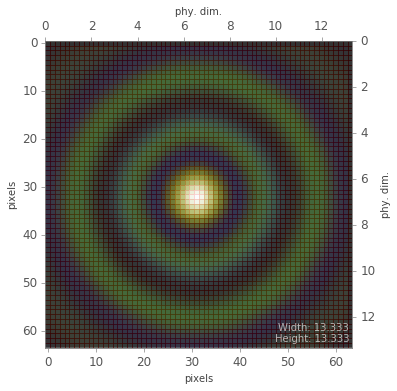

In [64]:
# zoomed-in to the central PSF in the field (object field)
show_around(img_data, pixX=64, pixY=64, pixGrid=True, pixSize= 1000*img_info.objHeight/img_info.ypix)

Compare this PSF with the PSF for which the field height was 1.0 mm (ten times larger field). It is evident that the former PSF is not an accurate respresentation of the actual PSF.

Now, before moving on to the next example, we will see the effect of increasing the image sampling parameter from 6x64 to 128x128. 

In [65]:
ln.zModifyImageSimulationSettings(settingsFile=cfgfile, imgSample=S128by128)

(0,)

In [66]:
img_info, img_data = ln.zGetImageSimulation(settingsFile=cfgfile)
img_info

PSFGridInfo(xpix=640, ypix=480, objHeight=0.1, fieldPos=0.0)

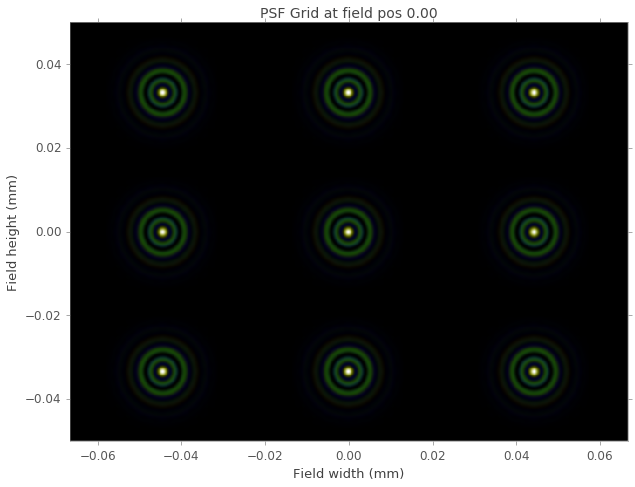

In [67]:
# PSF field in the object plane
show_image(img_data, img_info)

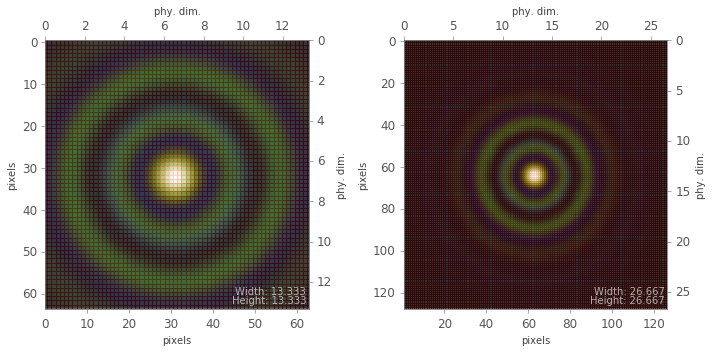

In [71]:
# zoomed-in to the central PSF in the field (object field)

# Here we plot the central PSF from the above PSF grid for two different window sizes. The left
# plot below shows a 64x64 pixel window and the right plot shows a 128x128 pixel window.
# Note that the left plot is exactly similar to the zoomed-in PSF in the simulation above. 
# This is indeed expected, we case we haven't modified oversampling or field height. 

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
# PSF data in 64 by 64 pixel window
show_around(img_data, pixX=64, pixY=64, pixGrid=True, ax=ax1, pixSize= 1000*img_info.objHeight/img_info.ypix)
# the same PSF about with 128 by 128 pixel window 
show_around(img_data, pixX=128, pixY=128, pixGrid=True, ax=ax2, pixSize=1000*img_info.objHeight/img_info.ypix)
fig.tight_layout()
plt.show()

Increasing the "Image Sampling" grid size does not increase the time required to generate the PSF grid. However, increasing the image sampling grid size increases the image simulation (with "Show As" option as Simulated Image), because each convolution takes longer time.

## Example 3 - A blue notch filter

In this example, the lens contains a blue notch filter. Therefore the image formed is devoid of any pure blue component of light. However, we need to set the polarization settings to obtain the correct simulation results. To demonstrate this effect, we will first generate a settings file without the polarization setting turned on. 

In [48]:
zmf_src = 'Example 3, A blue notch filter.ZMX'
zmf_dst = 'A Blue Notch Filter.ZMX'
lens_src = os.path.join(imgSimDir, zmf_src)
lens_dst = os.path.join(imgSimDir, zmf_dst)
shutil.copyfile(lens_src, lens_dst)
zmxFilesAdded.append(lens_dst)
ln.zLoadFile(lens_dst)

0

In [50]:
# Lens notes retrieved from the prescription file 
ln.ipzGetTextWindow('Pre', 7, 16)

LENS NOTES:

The glass plate has a coating that rejects the blue wavelength region. As a result,
the blue circle is not passed by the system. Note the 'Use Polarization' flag in
the Settings dialog of the Image Simulation feature must be on for the coating to
be accounted for.

As this design has no aberrations, the PSF grid is computed using a delta function.
This is faster than computing the geometric or diffraction psf which is unnecessary
as the design uses only a paraxial lens.


In [41]:
cfgfile = ln.zSetImageSimulationSettings(image='RGB_CIRCLES.BMP',
                                         height=1, wave=RGB, psfx=1, psfy=1,
                                         pupilSample=S32by32, imgSample=S32by32
                                        )

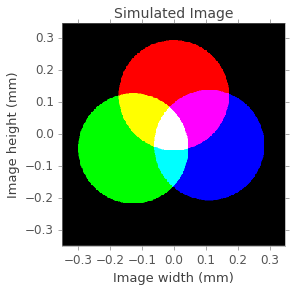

In [42]:
img_info, img_data = ln.zGetImageSimulation(settingsFile=cfgfile)
show_image(img_data, img_info, figsize=(4,4))

In [43]:
# turn on polarization 
ln.zModifyImageSimulationSettings(settingsFile=cfgfile, pol=1)

(0,)

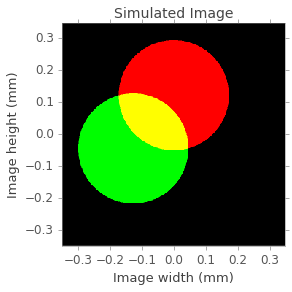

In [44]:
img_info, img_data = ln.zGetImageSimulation(settingsFile=cfgfile)
show_image(img_data, img_info, figsize=(4,4))

## Example 4 - A diffraction limited system

In [190]:
zmf_src = 'Example 4, a diffraction limited system.ZMX'
zmf_dst = 'A Diffraction limited system.ZMX'
lens_src = os.path.join(imgSimDir, zmf_src)
lens_dst = os.path.join(imgSimDir, zmf_dst)
shutil.copyfile(lens_src, lens_dst)
zmxFilesAdded.append(lens_dst)
ln.zLoadFile(lens_dst)

0

In [191]:
# Lens notes from the prescription file
ln.ipzGetTextWindow('Pre', 7, 16)

LENS NOTES:

In this file we image a simple object though the HST. The input scene subtends only
0.001 degrees field of view. Note that the Geometric Image Analysis feature predicts
a sharp image, because geometric calculations predict unphysically good imaging in
diffraction limited systems, but the Image Simulation correctly shows the blurring
due to the finite passband of the optical system.

Note also that the input scene is oversampled so that the resulting pixels are comparable
to the size of the PSFs in the grid.


In [9]:
# The field data shows that field is defined in terms of angles
ln.ipzGetFieldData()

Field Normalization : Radial
Type                : Angles in degrees
Number of Fields    : 3
Max Y               : 0.08
Max X               : 0.08
   X       Y     Weight   VDX     VDY     VCX     VCY     VAN   
 0.00    0.00   1.0000  0.0000  0.0000  0.0000  0.0000  0.0000  
 0.00    0.06   1.0000  0.0000  0.0000  0.0000  0.0000  0.0000  
 0.00    0.08   1.0000  0.0000  0.0000  0.0000  0.0000  0.0000  


In [10]:
# PSF Grid
cfgfile = ln.zSetImageSimulationSettings(image='LETTERF.IMA',
                                         height=0.0001, wave=RGB, psfx=3, psfy=3,
                                         pupilSample=S32by32, imgSample=S32by32,
                                         aberr=DIFF,showAs=PSFGRID, reference=CHIEF,
                                         over=X16
                                        )

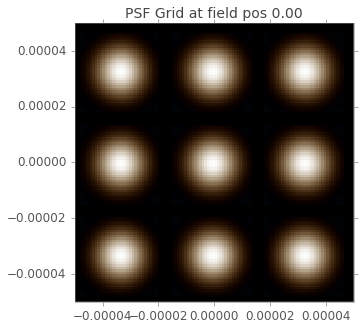

In [13]:
img_info, img_data = ln.zGetImageSimulation(settingsFile=cfgfile)
show_image(img_data, img_info, figsize=(5,5), xylabels=False)

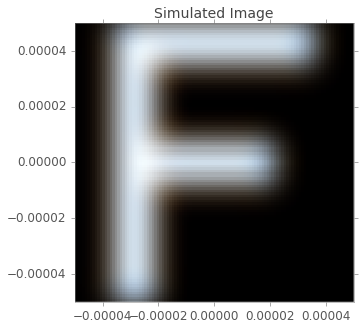

In [14]:
# simulated image
ln.zModifyImageSimulationSettings(settingsFile=cfgfile, showAs=SIMIMG)
img_info, img_data = ln.zGetImageSimulation(settingsFile=cfgfile)
show_image(img_data, img_info, figsize=(5,5), xylabels=False)

#### Effect of increasing oversampling on the PSF grid

Here we plot the PSF grid for various factors of oversampling. The pupil and image samling (under convolution grid settings) are kept constant at 32x32.

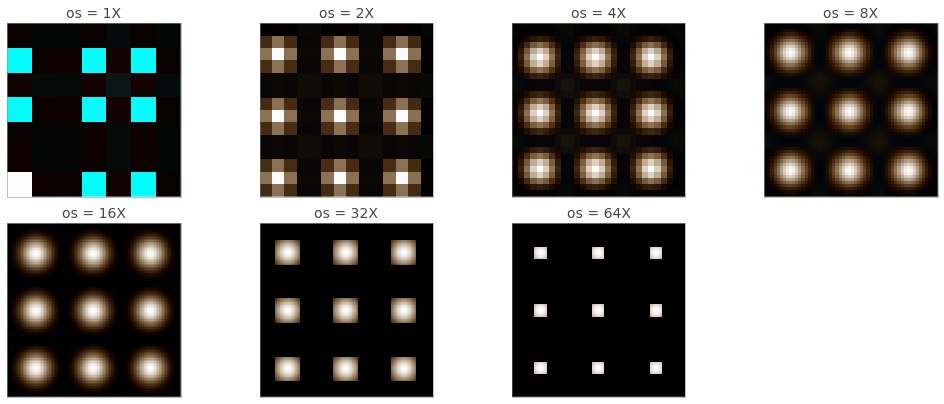

In [15]:
ln.zModifyImageSimulationSettings(settingsFile=cfgfile, showAs=PSFGRID)

fig, axes = plt.subplots(2, 4, figsize=(14, 6))
ax = axes.flatten()

for i in range(7):
    ln.zModifyImageSimulationSettings(settingsFile=cfgfile, over=i)
    _, img_data = ln.zGetImageSimulation(settingsFile=cfgfile)
    ax[i].imshow(np.array(img_data, dtype='uint8'), interpolation='none')
    ax[i].xaxis.set_ticks([])
    ax[i].yaxis.set_ticks([])
    ax[i].set_title('os = {}X'.format(2**i))

fig.tight_layout()
ax[7].set_visible(False)

plt.show()


Is the 32x and 64x oversampling is worse than the 16x oversampling factor? Weren't we expecting it to be better? Let's look a litte closer for the 32x oversampling for two different amounts of image sampling settings.

In [17]:
# oversampling : 32x , image sampling : 32x32
ln.zModifyImageSimulationSettings(settingsFile=cfgfile, over=X32, imgSample=S32by32)
img_info_x32_i32, img_data_x32_i32 = ln.zGetImageSimulation(settingsFile=cfgfile)

# # oversampling : 32x , image sampling : 64x64
ln.zModifyImageSimulationSettings(settingsFile=cfgfile, over=X32, imgSample=S64by64)
img_info_x32_i64, img_data_x32_i64 = ln.zGetImageSimulation(settingsFile=cfgfile)

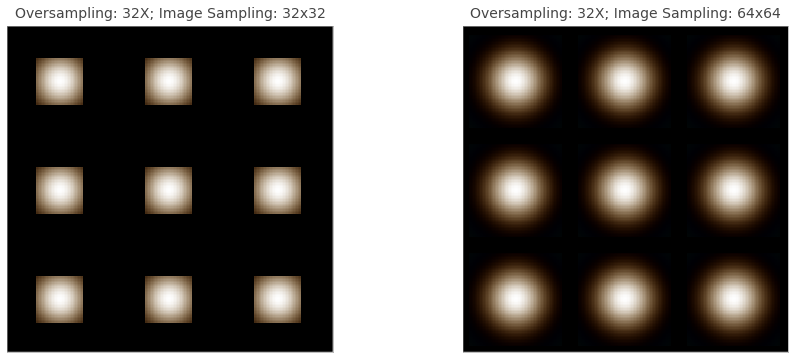

In [31]:
fig, axes = plt.subplots(1, 2, figsize=(14, 8))
ax = axes.flatten()
t = [ 'Oversampling: 32X; Image Sampling: 32x32',
      'Oversampling: 32X; Image Sampling: 64x64'
    ]
for i, img_data in enumerate([img_data_x32_i32, img_data_x32_i64]):
    ax[i].imshow(np.array(img_data, dtype='uint8'), interpolation='none')
    ax[i].xaxis.set_ticks([]); ax[i].yaxis.set_ticks([])
    ax[i].set_title(t[i], y=1.01)
plt.show()

Thus, we see that we also need to increase the image sampling under convolution grid settings to faithfully represent the oversampled PSF. This is because, if the pixel size is not explicitly specified under detector settings, it is determined by the transverse magnification, number of pixels in the source bitmap, field height and oversampling. When we increase the oversampling factor (or decrease the field height) while keeping other parameters constant, the pixel size decreases and therefore, the number of pixels per PSF increases. Thus the PSFs require more samples for complete representation. 

## Example 5 - Spatially varying resolution

In [27]:
zmf_src = 'Example 5, spatially varying resolution.ZMX'
zmf_dst = 'Spatially varying resolution.ZMX'
lens_src = os.path.join(imgSimDir, zmf_src)
lens_dst = os.path.join(imgSimDir, zmf_dst)
shutil.copyfile(lens_src, lens_dst)
zmxFilesAdded.append(lens_dst)
ln.zLoadFile(lens_dst)

0

In [28]:
# Lens notes from the prescription file
ln.ipzGetTextWindow('Pre', 7, 16)

LENS NOTES:

This example uses the same lens as example 2, but in this case a small (5mm) source
scene consisting of four grids of lines is moved vertically in the field of view.
The effects of lateral color and sagittal/tangential MTF can be clearly seen.

Note that at each field point the detector is centered on the field of view of interest.
Alternatively, the detector can be defined to be a single large detector that stays
at the same position as the image is moved. Use the 'Reference' control in the detector
settings to define exactly what you want.


In [29]:
# view the source file
IMAdir = os.path.join(usr, 'Documents\Zemax\IMAFiles')
filename = os.path.join(IMAdir, 'GRID_OF_BARS.BMP')
srcImg = imread(filename)

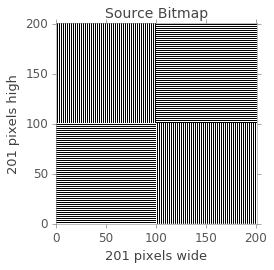

In [30]:
# please keep in mind that the displayed image will be aliased
info = co.namedtuple('src', ['xpix', 'ypix'])
img_info = info._make([201, 201])
show_image(srcImg, img_info, figsize=(3.6, 3.6))

In the source bitmap, there are 201 pixels along each direction. Also, in each of the four sub patches there are 0.5 line-pairs (lp)/pixel (along either directions). Since there are 201 pixels, we get 201*0.5 = 100.5 lp/ph. 'ph' stands for picture height. 

Therefore, if the field height (in image simulation) is 5 mm, then the object resolution is 100.5/5 = 20.1 lp/mm (in either the horizontal or vertical direction in four patches). And, if the field height is 1 mm, then the object resolution is 100.5 lp/mm.

With the above back-of-the-envelope calculation in mind, let's see the MTF of the system 

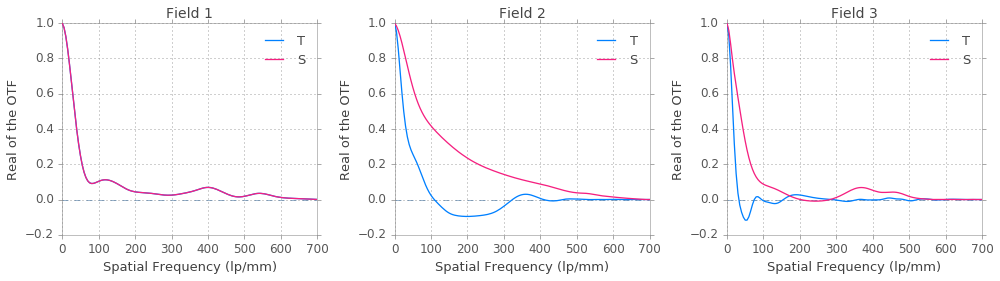

In [162]:
mtfcfg = ln.zSetFFTMTFSettings(sample=3, wave=0, field=2, dtype=1, surf=0)

fig, axes = plt.subplots(1, 3, figsize=(14, 4))
ax = axes.flatten()

for i in range(3):
    ln.zModifyFFTMTFSettings(settingsFile=mtfcfg, field=i+1)
    mtfs = ln.zGetMTF(which='fft', settingsFile=mtfcfg)
    for field, mtf in enumerate(mtfs):
        ax[i].plot(mtf.SpatialFreq, mtf.Tangential, label='T', zorder=20)
        ax[i].plot(mtf.SpatialFreq, mtf.Sagittal, label='S', zorder=20)
        ax[i].set_xlabel('Spatial Frequency (lp/mm)')
        ax[i].set_ylabel('Real of the OTF')
        ax[i].set_xlim(xmax=700)
        ax[i].grid('on'); ax[i].axhline(y=0, lw=0.5, linestyle='dashed')
        ax[i].legend()
        ax[i].set_title('Field {}'.format(i+1))
fig.tight_layout()
plt.show()

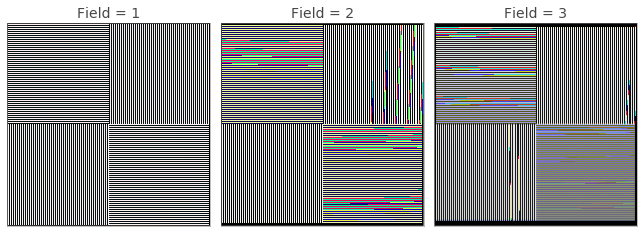

In [175]:
# Image Simulation (note that the aberration computation is "geometric")
cfgfile = ln.zSetImageSimulationSettings(image='GRID_OF_BARS.BMP',
                                         height=5, wave=RGB, flip=1,
                                         pupilSample=S32by32, imgSample=S32by32, 
                                         psfx=7, psfy=7, pixelSize=0.005, 
                                         xpix=1000, ypix=1000, aberr=GEOM,
                                         showAs=SIMIMG, reference=CHIEF,
                                        )

fig, axes = plt.subplots(1, 3, figsize=(9.05, 5))
ax = axes.flatten()

for i in range(3):
    ln.zModifyImageSimulationSettings(settingsFile=cfgfile, field=i+1)
    _, img_data = ln.zGetImageSimulation(settingsFile=cfgfile)
    ax[i].imshow(np.array(img_data, dtype='uint8'), interpolation='none')
    ax[i].xaxis.set_ticks([])
    ax[i].yaxis.set_ticks([])
    ax[i].set_title('Field = {}'.format(i+1))

fig.tight_layout()

plt.show()

In [179]:
ln.zModifyImageSimulationSettings(settingsFile=cfgfile, height=1, over=X2, 
                                  pixelSize=0.0005, xpix=0, ypix=0,
                                  pupilSample=S64by64, imgSample=S64by64,
                                  aberr=DIFF)

(0, 0, 0, 0, 0, 0, 0, 0)

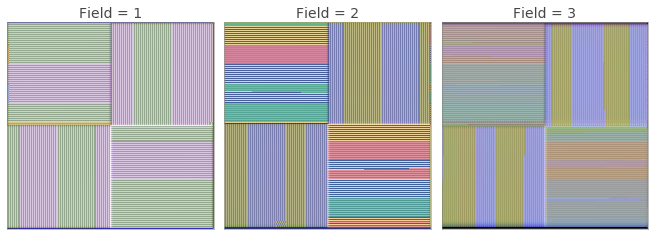

In [186]:
fig, axes = plt.subplots(1, 3, figsize=(9.2, 5))
ax = axes.flatten()

for i in range(3):
    ln.zModifyImageSimulationSettings(settingsFile=cfgfile, field=i+1)
    _, img_data = ln.zGetImageSimulation(settingsFile=cfgfile)
    ax[i].imshow(np.array(img_data, dtype='uint8'), interpolation='none')
    ax[i].xaxis.set_ticks([])
    ax[i].yaxis.set_ticks([])
    ax[i].set_title('Field = {}'.format(i+1))

fig.tight_layout()

plt.show()

In [187]:
ln.zModifyImageSimulationSettings(settingsFile=cfgfile, showAs=PSFGRID)

(0,)

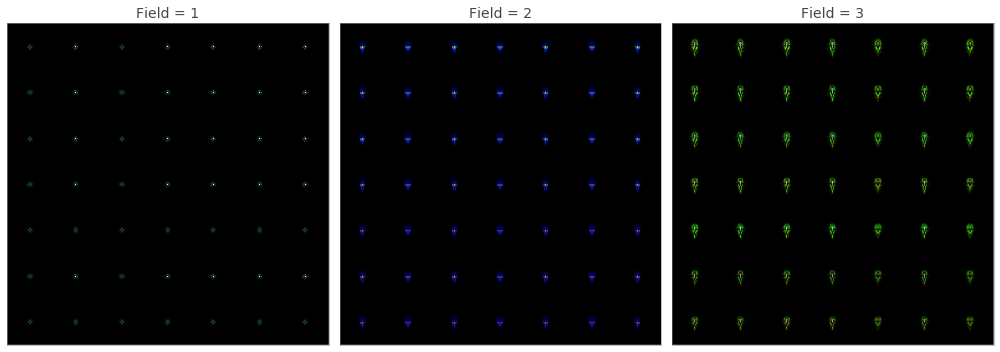

In [188]:
fig, axes = plt.subplots(1, 3, figsize=(14, 6))
ax = axes.flatten()

for i in range(3):
    ln.zModifyImageSimulationSettings(settingsFile=cfgfile, field=i+1)
    _, img_data = ln.zGetImageSimulation(settingsFile=cfgfile)
    ax[i].imshow(np.array(img_data, dtype='uint8'), interpolation='none')
    ax[i].xaxis.set_ticks([])
    ax[i].yaxis.set_ticks([])
    ax[i].set_title('Field = {}'.format(i+1))

fig.tight_layout()

plt.show()

## Example 6 - Tilted image plane

In [8]:
zmf_src = 'Example 6, tilted image plane.ZMX'
zmf_dst = 'Tilted image plane.ZMX'
lens_src = os.path.join(imgSimDir, zmf_src)
lens_dst = os.path.join(imgSimDir, zmf_dst)
shutil.copyfile(lens_src, lens_dst)
zmxFilesAdded.append(lens_dst)
ln.zLoadFile(lens_dst)

0

In [9]:
# Lens notes from the prescription file
ln.ipzGetTextWindow('Pre', 7, 16)

LENS NOTES:

Configuration 1 is diffraction limited across its field of view. The PSF grid may
need to be maximized for its details to be visible. Configuration 2 shows both image
and object surfaces tilted (use control-A to switch configurations).

ZEMAX automatically switches from diffraction to Geometric PSF calculation when the
spot is 20x the diffraction limit. This is done independently for each field and
wavelength. Note that the central x-slice is still diffraction limited, while the
top and bottom x-slices are geometrically aberrated.


In [10]:
# Let's start with configuration 1
ln.zSetConfig(1)

(1, 2, 0)

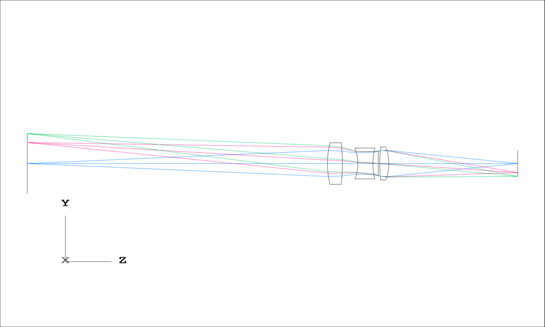

In [11]:
# Layout plot
ln.ipzCaptureWindow('L3d')

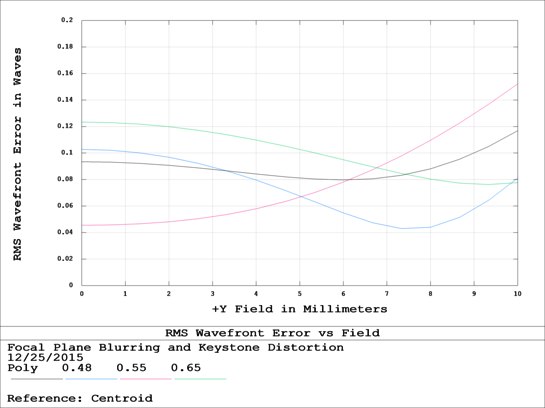

In [12]:
# RMS vs Field plot
ln.ipzCaptureWindow('Rms', percent=15, gamma=0.4)

In [15]:
# setup image simulation. Note that the parameters set herein is a little different
# from the values sets originally in the examples. Especially, I have increased the
# oversampling factor from None to 2x, changed the field height from 10 mm in the 
# object space to 5 mm, changed the pixel size from 0.006 mm to 0.005 mm, and the 
# detector dimension from 1280x960 pixels to 700x550 pixels. These modifications
# were done to sample the diffraction limited PSF adequately.

cfgfile = ln.zSetImageSimulationSettings(image='Demo picture -  640 x 480.bmp',
                                         height=5, field=1, wave=RGB, flip=1,
                                         pupilSample=S64by64, imgSample=S64by64, 
                                         psfx=7, psfy=7, pixelSize=0.005, 
                                         xpix=700, ypix=550, aberr=DIFF,
                                         showAs=SIMIMG, reference=CHIEF,
                                         over=X2
                                        )


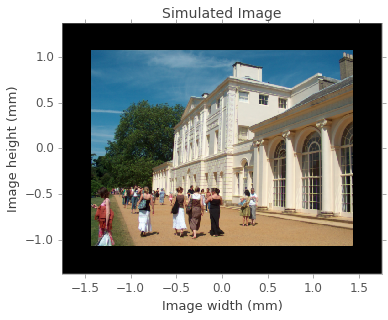

In [16]:
img_info, img_data = ln.zGetImageSimulation(settingsFile=cfgfile, timeout=240)
show_image(img_data, img_info, figsize=(6, 4.5))

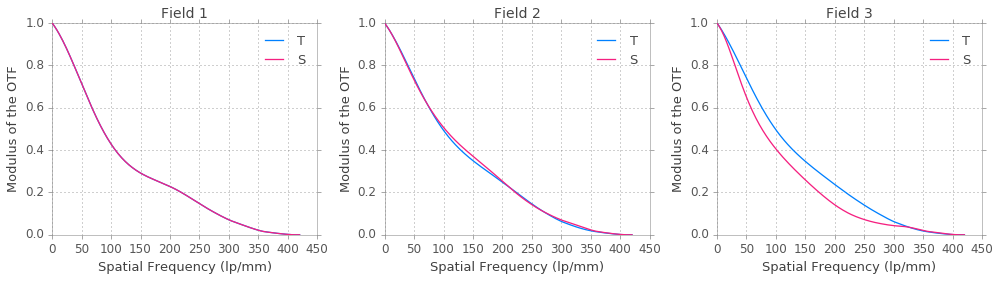

In [17]:
# MTF vs Field plots

mtfcfg = ln.zSetFFTMTFSettings(sample=3, wave=0, dtype=0, surf=0)

fig, axes = plt.subplots(1, 3, figsize=(14, 4))
ax = axes.flatten()

for i in range(3):
    ln.zModifyFFTMTFSettings(settingsFile=mtfcfg, field=i+1)
    mtfs = ln.zGetMTF(which='fft', settingsFile=mtfcfg)
    for field, mtf in enumerate(mtfs):
        ax[i].plot(mtf.SpatialFreq, mtf.Tangential, label='T', zorder=20)
        ax[i].plot(mtf.SpatialFreq, mtf.Sagittal, label='S', zorder=20)
        ax[i].set_xlabel('Spatial Frequency (lp/mm)')
        ax[i].set_ylabel('Modulus of the OTF')
        ax[i].set_xlim(xmax=450)
        ax[i].grid('on')
        ax[i].legend()
        ax[i].set_title('Field {}'.format(i+1))
fig.tight_layout()
plt.show()

The plots qualitatively show that the optical spatial resolution is mostly uniform across the field.

In [18]:
# Now let's start with configuration 2, in which the system 
# encounters focal plane blurring and keystone distortion
ln.zSetConfig(2)

(2, 2, 0)

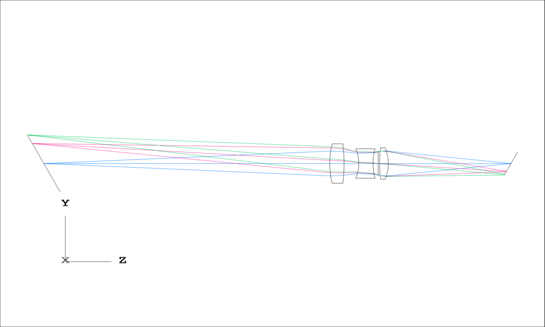

In [19]:
# Layout plot
ln.ipzCaptureWindow('L3d')

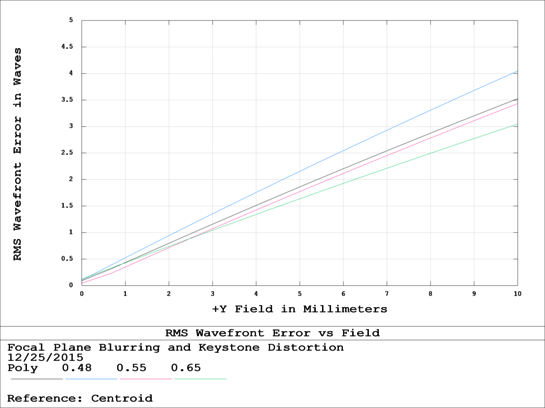

In [20]:
# RMS vs Field plot
ln.ipzCaptureWindow('Rms', percent=15, gamma=0.4)

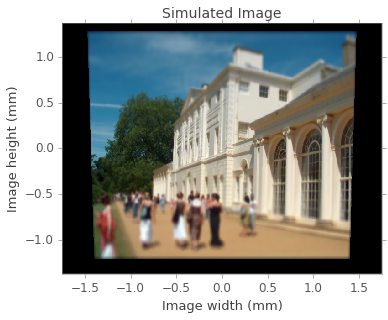

In [21]:
# image simulation (we will use the same settings as before)
img_info, img_data = ln.zGetImageSimulation(settingsFile=cfgfile, timeout=240)
show_image(img_data, img_info, figsize=(6, 4.5))

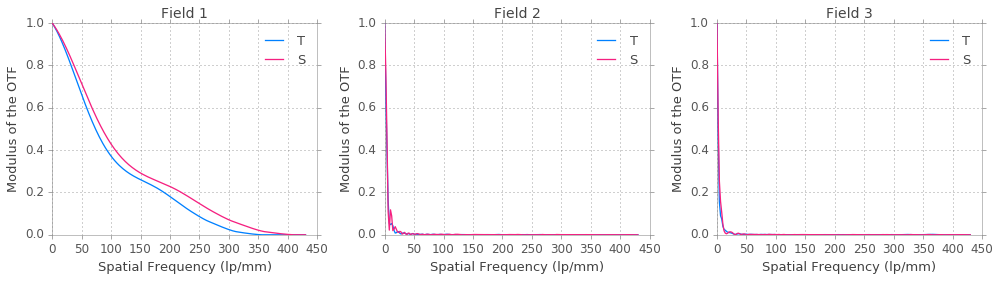

In [22]:
# MTF vs Field

fig, axes = plt.subplots(1, 3, figsize=(14, 4))
ax = axes.flatten()

for i in range(3):
    ln.zModifyFFTMTFSettings(settingsFile=mtfcfg, field=i+1)
    mtfs = ln.zGetMTF(which='fft', settingsFile=mtfcfg)
    for field, mtf in enumerate(mtfs):
        ax[i].plot(mtf.SpatialFreq, mtf.Tangential, label='T', zorder=20)
        ax[i].plot(mtf.SpatialFreq, mtf.Sagittal, label='S', zorder=20)
        ax[i].set_xlabel('Spatial Frequency (lp/mm)')
        ax[i].set_ylabel('Modulus of the OTF')
        ax[i].set_xlim(xmax=450)
        ax[i].grid('on')
        ax[i].legend()
        ax[i].set_title('Field {}'.format(i+1))
fig.tight_layout()
plt.show()

As expected, the MTF vs Field plots depict that the on-axis optical spatial frequency is intact while it has reduced by over a factor of 10 for off-axis field points. Let's view the PSF grid.

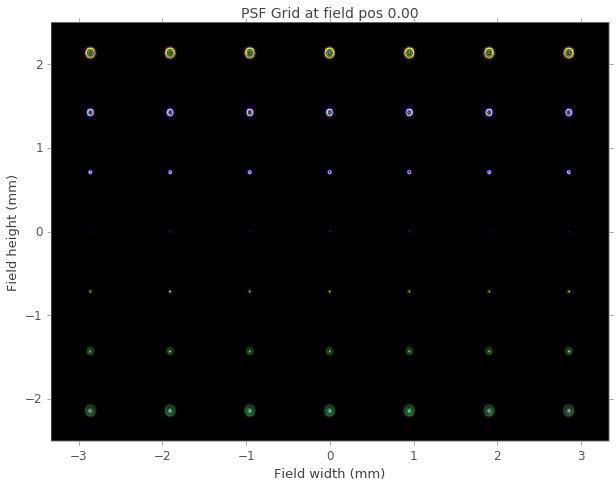

In [23]:
# PSF grid
ln.zModifyImageSimulationSettings(settingsFile=cfgfile, showAs=PSFGRID)
img_info, img_data = ln.zGetImageSimulation(settingsFile=cfgfile)
show_image(img_data, img_info)

Can we optimize the tilt to get diffraction limited resolution across the field in the tilted configuration? 

In order to do so, we will place a variable solve on the Tilt-About-x surface parameter (Param 3) of surface 8. However, since this parameter is also an operand (row 4) in the Multi-Configuration-Editor (MCE) we cannot set the solve in the LDE (i.e. we cannot use `zSetSolve()`); instead, we need to set the variable solve in the MCE (using `zSetMulticon()`). But, first, we will remove all other optimization variables.

In [24]:
ln.zRemoveVariables()

0

In [25]:
# status=1 is to set Variable solve. Also note that we are (re-)setting the value of that
# parameter to 0.0. Resetting this value is not critical though.
config=2; row=4; value=0.0; status=1; pickupRow=0; pickupConfig=0; scale=1; offset=0
ln.zSetMulticon(config, row, value, status, pickupRow, pickupConfig, scale, offset)

MCD(value=0.0, numConfig=2, numRow=4, status=1, pickupRow=0, pickupConfig=0, scale=1.0, offset=0.0)

Let's vew the contents (partial) of the Multi-Function Editor see what's in there.

In [27]:
ln.ipzGetMFE(start_row=1, end_row=10)

Multi-Function Editor contents:
  Oper    int1  int2   data1   data2   data3   data4   data5    Target  Weight     Value
  CONF    1.00  0.00  0.0000  0.0000  0.0000  0.0000  0.0000  0.000000  0.0000  0.000000
  DMFS    0.00  0.00  0.0000  0.0000  0.0000  0.0000  0.0000  0.000000  0.0000  0.000000
  BLNK  Default merit function: RMS spot radius centroid GQ 4 rings 6 arms
  BLNK  Default air thickness boundary constraints.
  MNCA    0.00  7.00  0.0000  0.0000  0.0000  0.0000  0.0000  0.500000  1.0000  0.000000
  MXCA    0.00  7.00  0.0000  0.0000  0.0000  0.0000  0.0000101.000000  1.0000  0.000000
  MNEA    0.00  7.00  0.0000  0.0000  0.0000  0.0000  0.0000  0.500000  1.0000  0.000000
  BLNK  Default glass thickness boundary constraints.
  MNCG    0.00  7.00  0.0000  0.0000  0.0000  0.0000  0.0000  1.000000  1.0000  0.000000
  MXCG    0.00  7.00  0.0000  0.0000  0.0000  0.0000  0.0000  5.000000  1.0000  0.000000


From the above output, we can see that a default merit function (DMFS) was set for configuration 1 (`opertype='CONF'` and `int1=1`). This was done perhaps to find the optimum radii of curvatures and thickness of the lens elements to that reduced the RMS spot radius on the image surface in configuration 1 (i.e. when the object, image and lens planes were parallel to each other).

We would like to optimize over the Tilt-About-x angle (i.e the image plane tilt angle about the x-axis) to get diffraction limited resolution across the field. Since configuration 2 is the tilted configuration, and we have already set a variable solve for tilt parameter in configuration 2, we will change the default merit function to affect configuration 2.

In [28]:
# Set the CONF operand to 2 (i.e. the current configuration)
ln.zSetOperandRow(row=1, opertype='CONF', int1=2)

OperandData(opertype='CONF', int1=2.0, int2=0.0, data1=0.0, data2=0.0, data3=0.0, data4=0.0, data5=0.0, data6=0.0, tgt=0.0, wgt=0.0, value=0.0, percentage=0.0)

In [29]:
# updates all operands in the merit function and returns the current merit function
# without performing optimization.
ln.zOptimize(-1)

0.03087159096275

In [30]:
# now optimize using default parameters
ln.zOptimize()

0.001430753897808

In [31]:
# Optimized x-tilt angle = the value=13.89935765954
ln.zGetMulticon(config=2, row=4)

MCD(value=13.89935765954, numConfig=2, numRow=4, status=1, pickupRow=0, pickupConfig=0, scale=1.0, offset=0.0)

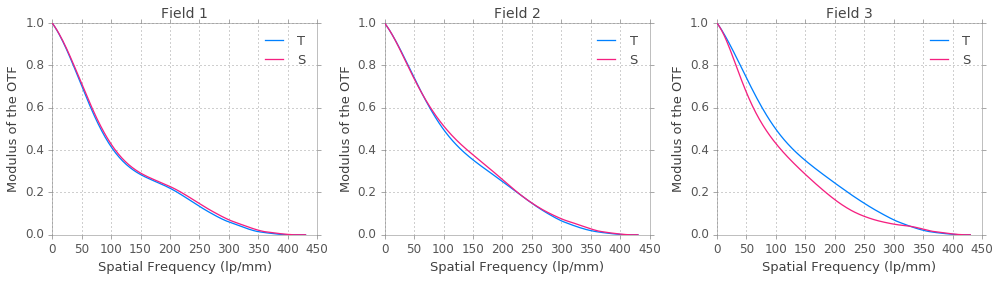

In [32]:
# MTF vs Field

fig, axes = plt.subplots(1, 3, figsize=(14, 4))
ax = axes.flatten()

for i in range(3):
    ln.zModifyFFTMTFSettings(settingsFile=mtfcfg, field=i+1)
    mtfs = ln.zGetMTF(which='fft', settingsFile=mtfcfg)
    for field, mtf in enumerate(mtfs):
        ax[i].plot(mtf.SpatialFreq, mtf.Tangential, label='T', zorder=20)
        ax[i].plot(mtf.SpatialFreq, mtf.Sagittal, label='S', zorder=20)
        ax[i].set_xlabel('Spatial Frequency (lp/mm)')
        ax[i].set_ylabel('Modulus of the OTF')
        ax[i].set_xlim(xmax=450)
        ax[i].grid('on')
        ax[i].legend()
        ax[i].set_title('Field {}'.format(i+1))
fig.tight_layout()
plt.show()

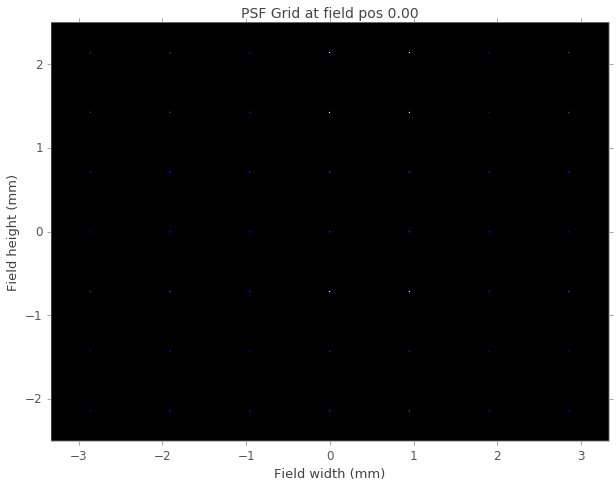

In [33]:
# PSF grid
img_info, img_data = ln.zGetImageSimulation(settingsFile=cfgfile)
show_image(img_data, img_info)

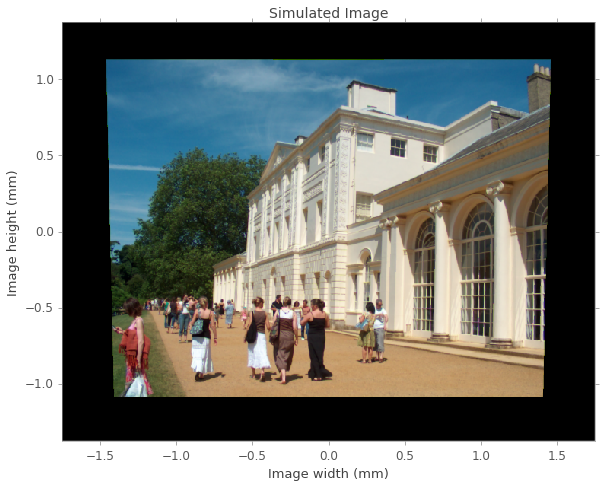

In [34]:
# Image simulation
ln.zModifyImageSimulationSettings(settingsFile=cfgfile, showAs=SIMIMG)
img_info, img_data = ln.zGetImageSimulation(settingsFile=cfgfile)
show_image(img_data, img_info, figsize=(6, 4.5))

Note that there is no blurring at off-axis field positions; however the keystoning effect is still present because of the tilt of the image plane.

In [72]:
def clean_up_directory():
    for f in zmxFilesAdded:
        try:
            os.remove(f)
        except:
            print("Couldn't remove {}".format(f))
        else:
            print("Removed {}".format(f))

clean_up_directory()

Removed C:\Users\Indranil\Documents\Zemax\Samples\Sequential\Image Simulation\A Singlet Eyepiece.ZMX
Removed C:\Users\Indranil\Documents\Zemax\Samples\Sequential\Image Simulation\Double Gauss Experimental.ZMX


In [73]:
ln.close()